<a href="https://colab.research.google.com/github/jonkrohn/ML-foundations/blob/master/notebooks/8-optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization

This class, *Optimization*, is the eighth of eight classes in the *Machine Learning Foundations* series. It builds upon the material from each of the other classes in the series -- on linear algebra, calculus, probability, statistics, and algorithms -- in order to provide a detailed introduction to training machine learning models. 

Through the measured exposition of theory paired with interactive examples, you’ll develop a working understanding of all of the essential theory behind the ubiquitous gradient descent approach to optimization as well as how to apply it yourself -- both at a granular, matrix operations level and a quick, abstract level -- with TensorFlow and PyTorch. You’ll also learn about the latest optimizers, such as Adam and Nadam, that are widely-used for training deep neural networks. 

Over the course of studying this topic, you'll:

* Discover how the statistical and machine learning approaches to optimization differ, and why you would select one or the other for a given problem you’re solving.
* Find out how the extremely versatile (stochastic) gradient descent optimization algorithm works, including how to apply it -- from a low, in-depth level as well as from a high, abstracted level -- within the most popular deep learning libraries, Tensorflow and PyTorch
* Get acquainted with the “fancy” optimizers that are available for advanced machine learning approaches (e.g., deep learning) and when you should consider using them.

Note that this Jupyter notebook is not intended to stand alone. It is the companion code to a lecture or to videos from Jon Krohn's [Machine Learning Foundations](https://github.com/jonkrohn/ML-foundations) series, which offer detail on the following:

*Segment 1: The Machine Learning Approach to Optimization*

* The Statistical Approach to Regression: Ordinary Least Squares
* When Statistical Approaches to Optimization Breakdown
* The Machine Learning Solution 

*Segment 2: Gradient Descent*

* Objective Functions
* Cost / Loss / Error Functions
* Minimizing Cost with Gradient Descent
* The Global Minimum and Local Minima
* Saddle Points
* Maximizing Reward with Gradient Ascent 
* Learning Rate
* Point-by-Point Regression in TensorFlow / PyTorch
* Tensor-Based Regression in TensorFlow / PyTorch
* Mini-Batches and Stochastic Gradient Descent (SGD)
* Regression with SGD in TensorFlow / PyTorch
* The Jacobian and the Hessian

*Segment 3: Fancy Deep Learning Optimizers*

* Momentum
* Nesterov Momentum
* AdaGrad
* AdaDelta 
* RMSProp
* Adam 
* Nadam
* A Layer of Artificial Neurons in TensorFlow / PyTorch
* Training a Deep Neural Net with SGD

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Segment 1: Optimization Approaches

Refer to the slides and the *Ordinary Least Squares* section of the [*Intro to Stats* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/6-statistics.ipynb).

## Segment 2: Gradient Descent

### Cost Functions

Fundamentally, for some instance $i$, we'd like to quantify the difference between the "correct" target model output $y_i$ and the model's predicted output $\hat{y}_i$. A first idea might be to take the simple difference: $$\Delta y_i = \hat{y}_i - y_i$$

For computational efficiency (we'll explore this later in the segment), in ML we seldom consider the cost associated with a single instance $i$. Instead, we typically consider several instances simultaneously, in which case calculating the simple difference is largely  ineffective because positive and negative $\Delta y_i$ values cancel out. E.g., consider a situation where: 

* $\Delta y_1 = \hat{y}_1 - y_1$ = 7 - 2 = 5
* $\Delta y_2 = \hat{y}_2 - y_2$ = 3 - 8 = -5

On an individual-instance basis, there are differences between the predicted and target outputs, indicating the model could be improved. Despite this, the total cost ($\Sigma \Delta y_i = \Delta y_1 + \Delta y_2 = 5-5$) is zero and therefore the mean cost ($\frac{\Sigma{\Delta y_i}}{n} = \frac{0}{2}$) is also zero, erroneously implying a perfect model fit.

#### Mean Absolute Error

A straightforward resolution to the simple-difference shortcoming is to take the absolute value of the difference. I.e., using the same contrived values as above: 

* $|\Delta y_1| = |\hat{y}_1 - y_1|$ = |7 - 2| = 5
* $|\Delta y_2| = |\hat{y}_2 - y_2|$ = |3 - 8| = 5

In this case:

* The total error is ten: $\Sigma |\Delta y_i| = |\Delta y_1| + |\Delta y_2| = 5+5$ 
* The **mean absolute error** (MAE) is five: $\frac{\Sigma{|\Delta y_i}|}{n} = \frac{10}{2}$

#### Mean squared error

While MAE satisfactorily quantifies cost across multiple instances, for reasons we'll numerate in a moment, it is much more common in ML to use **mean *squared* error** (MSE). 

Let's use the contrived values again to show how MSE is calculated. As covered in [*Calculus II*](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/4-calculus-ii.ipynb), the individual-instance variant of MSE is *squared error* or *quadratic cost*, which -- as with absolute error -- dictates that the cost for each instance $i$ must be $\geq 0$: 

* $(\hat{y}_1 - y_1)^2 = (7 - 2)^2 = 5^5 = 25$
* $(\hat{y}_2 - y_2)^2 = (3 - 8)^2 = 5^5 = 25$

As suggested by its name, MSE is the average: $$C = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 = \frac{1}{2} (25 + 25) = \frac{50}{2} = 25 $$

Since cost for each instance $i$ must be $\geq 0$, MSE (as with MAE) must therefore also be $\geq 0$. In addition: 

1. The partial derivative of the MSE $C$ can be efficiently computed w.r.t. model parameters, providing a *gradient* of cost, $\nabla C$ (the primary focus of [*Calculus II*](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/4-calculus-ii.ipynb) is deriving $\nabla C$). Adjusting model parameters, we can *descend* $\nabla C$ and thereby minimize $C$ (the mechanics of which are the primary focus of *Optimization*).
2. Compared to MAE, MSE is relatively tolerant of small $\Delta y_i$ and intolerant of large $\Delta y_i$, a characteristic that tends to lead to better-fitting models.

In [2]:
delta_y = np.linspace(-5, 5, 1000)

In [3]:
abs_error = np.abs(delta_y)

In [4]:
sq_error = delta_y**2

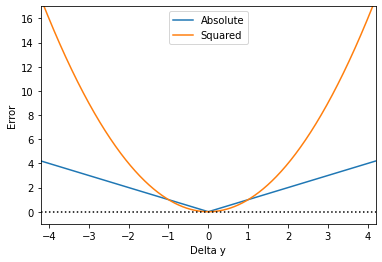

In [7]:
fig, ax = plt.subplots()

plt.plot(delta_y, abs_error)
plt.plot(delta_y, sq_error)
ax.axhline(c='black', linestyle='dotted')

plt.xlabel('Delta y')
plt.ylabel('Error')

ax.set_xlim(-4.2, 4.2)
ax.set_ylim(-1, 17)
_ = ax.legend(['Absolute', 'Squared'])

Refer to the following notebooks:
    
* [*Gradient Descent from Scratch*](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/gradient-descent-from-scratch.ipynb)
* [*SGD from Scratch*](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/SGD-from-scratch.ipynb)